# Machine Learning Pipeline

In [64]:
import re

import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

## Read CSV

In [65]:
df = pd.read_csv('./credit-data.csv', index_col='PersonID')
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


In [66]:
#covert a string that is camelcase into snake_case
def camel_to_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# convert each column name to snake case
df.columns = [camel_to_snake(col) for col in df.columns]
label_name = 'serious_dlqin2yrs'
feature_names = [col for col in df.columns if col != label_name]
df.head()

,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
PersonID,,,,,,,,,,,,
1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0


## Explore Data

In [67]:
df.count()

serious_dlqin2yrs                              150000
revolving_utilization_of_unsecured_lines       150000
age                                            150000
zipcode                                        150000
number_of_time30-59_days_past_due_not_worse    150000
debt_ratio                                     150000
monthly_income                                 120269
number_of_open_credit_lines_and_loans          150000
number_of_times90_days_late                    150000
number_real_estate_loans_or_lines              150000
number_of_time60-89_days_past_due_not_worse    150000
number_of_dependents                           146076
dtype: int64

In [68]:
#figure out which variables contain null values. First, melt our data into long format.print a table telling the no of null and non-null instances.
df_lng = pd.melt(df)
null_variables = df_lng.value.isnull()
pd.crosstab(df_lng.variable, null_variables)

value,False,True
variable,,
age,150000,0
debt_ratio,150000,0
monthly_income,120269,29731
number_of_dependents,146076,3924
number_of_open_credit_lines_and_loans,150000,0
number_of_time30-59_days_past_due_not_worse,150000,0
number_of_time60-89_days_past_due_not_worse,150000,0
number_of_times90_days_late,150000,0
number_real_estate_loans_or_lines,150000,0


## Pre Process Data

In [69]:
def check_missing(df):
    return [col for col in df.columns if any(df[col].isnull()) == True]

def fill_missing(df, col_name, method):
    if method == 'mean':
        df[col_name] = df[col_name].fillna(df[col_name].mean())
    elif method == 'median':
        df[col_name] = df[col_name].fillna(df[col_name].median())
    elif method == 'zero':
        df[col_name] = df[col_name].fillna(0)
        
missing_cols = check_missing(df)
missing_cols

['monthly_income', 'number_of_dependents']

In [70]:
for col in missing_cols:
    fill_missing(df, col, 'mean')
check_missing(df)

[]

As we can see, there is no missing values.

In [71]:
# encode zipcode by unique number idx
df['zipcode'] = df['zipcode'].astype('category').cat.codes
df[['zipcode', 'age']].groupby('zipcode').count()

,age
zipcode,
0,16599
1,16612
2,33514
3,16840
4,16625
5,16581
6,16624
7,16605


##  Generate Features

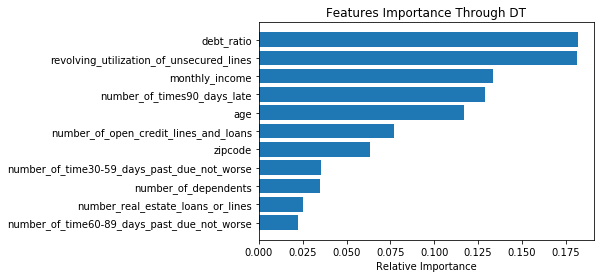

In [72]:
def sort_features_through_dt(df_features, df_label):
    features = df_features.columns
    model = DecisionTreeClassifier()
    model.fit(df_features, df_label)
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)
    padding = np.arange(len(features)) + 0.5
    plt.barh(padding, importances[sorted_idx], align='center')
    plt.yticks(padding, np.asarray(features)[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Features Importance Through DT")
    
    return list(np.asarray(features)[sorted_idx][::-1])


df_features, df_label = df[feature_names], df[label_name]

# sort all the features by importance
sorted_features = sort_features_through_dt(df_features, df_label)

In [73]:
# Select top 2/3 features
count = int(len(sorted_features) * 0.67)
df_features = df_features[sorted_features[:count]]
df_features.head()

,debt_ratio,revolving_utilization_of_unsecured_lines,monthly_income,number_of_times90_days_late,age,number_of_open_credit_lines_and_loans,zipcode
PersonID,,,,,,,
1,0.802982,0.766127,9120.0,0,45,13,5
2,0.121876,0.957151,2600.0,0,40,4,4
3,0.085113,0.658180,3042.0,1,38,2,0
4,0.036050,0.233810,3300.0,0,30,5,0
5,0.024926,0.907239,63588.0,0,49,7,2


In [74]:
# normalize
df_features = preprocessing.MinMaxScaler().fit_transform(df_features)
df_features = preprocessing.normalize(df_features, norm='max')

## Build Classifier

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve, auc,
                             precision_score, recall_score, f1_score)

In [76]:
# split train set and test set
df_features, df_label = df_features[:10000], df_label[:10000]
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2)

In [77]:
classifier_constructors = {
    'LR': LogisticRegression,
    'KNN': KNeighborsClassifier,
    'DT': DecisionTreeClassifier,
    'SVM': LinearSVC,
    'RF': RandomForestClassifier,
    'GB': GradientBoostingClassifier,
    'BG': BaggingClassifier
}

grid = dict()
grid['LR'] = {'penalty': ['l1', 'l2'], 'C': [10 ** i for i in range(-5, 2)]}
grid['DT'] = {'max_depth': [1, 5, 10, 20, 50, 100],
              'min_samples_split': [2, 5, 10]}
grid['KNN'] = {'n_neighbors': [1, 5, 10, 25, 50, 100]}
grid['SVM'] = {'C': [0.1, 0.5, 1]}
grid['RF'] = {'n_estimators': [1, 5, 10], 'max_depth': [1, 5, 10]}
grid['GB'] = {'n_estimators': [1, 5, 10], 'learning_rate': [0.1, 0.3, 0.5],
              'max_depth': [1, 3, 5]}
grid['BG'] = {'n_estimators': [1, 5, 10]}

In [78]:
def build_clf(X_train, y_train):
    classifiers = dict()
    for k, clf_constructor in classifier_constructors.items():
        clf = GridSearchCV(clf_constructor(), grid[k], cv=5)
        clf.fit(X_train, y_train)
        classifiers[k] = clf
        print('%s best params: %s, best score: %.4f' % (k, clf.best_params_, clf.best_score_))
    
    return classifiers

    
classifiers = build_clf(X_train, y_train)

LR best params: {'C': 1, 'penalty': 'l1'}, best score: 0.9354
KNN best params: {'n_neighbors': 25}, best score: 0.9354
DT best params: {'max_depth': 1, 'min_samples_split': 2}, best score: 0.9351
SVM best params: {'C': 0.1}, best score: 0.9351
RF best params: {'max_depth': 10, 'n_estimators': 10}, best score: 0.9366
GB best params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 1}, best score: 0.9361
BG best params: {'n_estimators': 10}, best score: 0.9287


## Evaluate Classifier

### Calculate precision, recall, f1, and auc

In [79]:
# evalute metrics
def evaluate_classifier(y_test, y_pre, y_prob):
    return {
        'precision': float("%.4f" % precision_score(y_test, y_pre)),
        'recall': float("%.4f" % recall_score(y_test, y_pre)),
        'f1': float("%.4f" % f1_score(y_test, y_pre)),
        'auc': float("%.4f" % roc_auc_score(y_test, y_prob))
    }

def evaluate_classifiers(X_test, y_test, threshold):
    metrics = dict()
    probas = dict()
    for k, clf in classifiers.items():
        if hasattr(clf, 'predict_proba'):
            y_prob = clf.predict_proba(X_test)[:, 1]
        else:
            y_prob = clf.decision_function(X_test)
        y_pre = np.asarray([1 if run >= threshold else 0 for run in y_prob])
        metrics[k] = evaluate_classifier(y_test, y_pre, y_prob)
        probas[k] = y_prob
    return metrics, probas
        
metrics, probas = evaluate_classifiers(X_test, y_test, 0.05)
metrics

{'BG': {'auc': 0.6791, 'f1': 0.186, 'precision': 0.1103, 'recall': 0.595},
 'DT': {'auc': 0.6641, 'f1': 0.3629, 'precision': 0.3543, 'recall': 0.3719},
 'GB': {'auc': 0.7731, 'f1': 0.1141, 'precision': 0.0605, 'recall': 1.0},
 'KNN': {'auc': 0.5731, 'f1': 0.1376, 'precision': 0.0803, 'recall': 0.4793},
 'LR': {'auc': 0.6402, 'f1': 0.1146, 'precision': 0.0608, 'recall': 0.9917},
 'RF': {'auc': 0.774, 'f1': 0.2196, 'precision': 0.1304, 'recall': 0.6942},
 'SVM': {'auc': 0.6558, 'f1': 0.032, 'precision': 0.5, 'recall': 0.0165}}

### Draw AUC

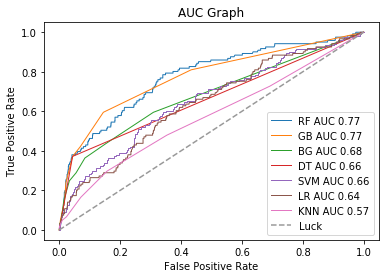

In [80]:
def draw_auc(probas, y_test):
    plt.clf()
    auc_list = []
    for k, prob in probas.items():
        fpr, tpr, thresholds = roc_curve(y_test, prob)
        roc_auc = auc(fpr, tpr)
        auc_list.append((k, roc_auc))
        
    auc_list.sort(key=lambda x: x[1], reverse=True)
    
    for k, roc_auc in auc_list:
        fpr, tpr, thresholds = roc_curve(y_test, probas[k])
        plt.plot(fpr, tpr, lw=1, label=('%s AUC %.2f' % (k, roc_auc)))
    
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Graph')
    plt.legend(loc="lower right")

draw_auc(probas, y_test)

### Draw Precision-Recall Curves

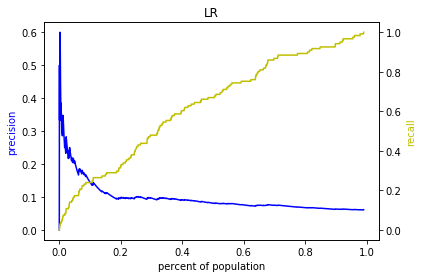

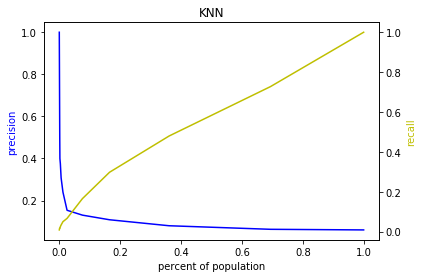

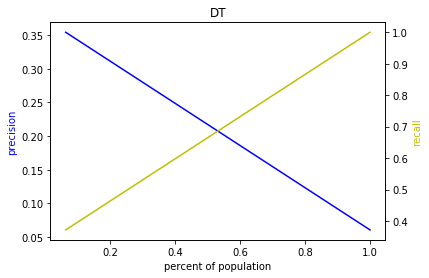

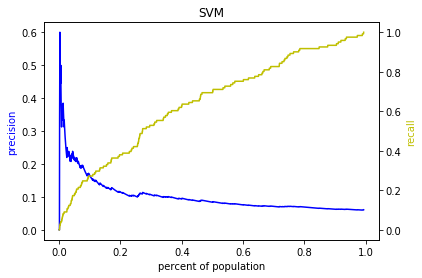

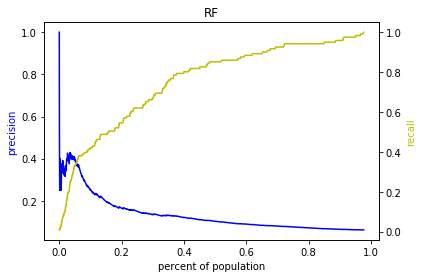

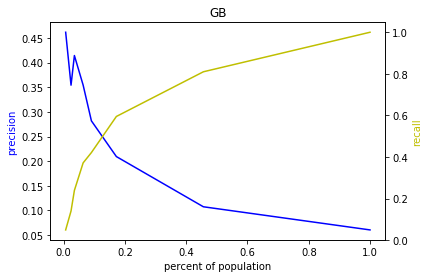

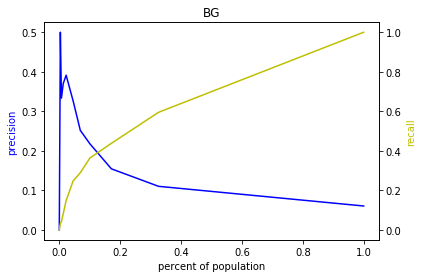

In [81]:
def plot_precision_recall(y_test, key):
    plt.clf()
    y_prob = probas[key]
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_prob)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_per_thresh = []
    number_scored = len(y_prob)
    for value in pr_thresholds:
        num_above_thresh = len(y_prob[y_prob >= value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_per_thresh.append(pct_above_thresh)
    pct_per_thresh = np.array(pct_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_per_thresh, recall_curve, 'y')
    ax2.set_ylabel('recall', color='y')
    plt.title(key)
    plt.show()
    
for key in probas.keys():
    plot_precision_recall(y_test, key)

### Draw Precision, Recall, Auc and F1

In [82]:
data = dict()
data['key'] =  ['precision', 'recall', 'f1', 'auc']

for k, metric in metrics.items():
    data[k] = [metric[item] for item in data['key']]

df_result = pd.DataFrame(data)

df_result = df_result.set_index('key')
df_result.head()

,BG,DT,GB,KNN,LR,RF,SVM
key,,,,,,,
precision,0.1103,0.3543,0.0605,0.0803,0.0608,0.1304,0.5000
recall,0.5950,0.3719,1.0000,0.4793,0.9917,0.6942,0.0165
f1,0.1860,0.3629,0.1141,0.1376,0.1146,0.2196,0.0320
auc,0.6791,0.6641,0.7731,0.5731,0.6402,0.7740,0.6558


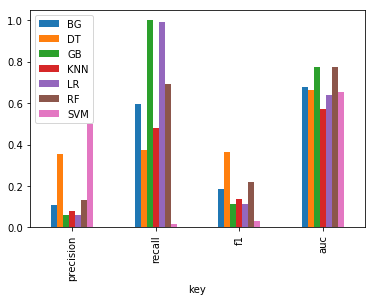

In [83]:
df_result.plot.bar();
plt.show()

### The Best Classifier

In [84]:
# find the best one
def find_the_best_model(target='auc'):
    metrics_list = list(metrics.items())
    metrics_list.sort(key=lambda x: x[1][target], reverse=True)
    return metrics_list[0]

find_the_best_model('precision')

('SVM', {'auc': 0.6558, 'f1': 0.032, 'precision': 0.5, 'recall': 0.0165})

In [85]:
def get_baseline_metric():
    base_clf = DummyClassifier()
    base_clf.fit(X_train, y_train)
    y_pre = base_clf.predict(X_test)
    y_prob = base_clf.predict_proba(X_test)[:, 1]
    return evaluate_classifier(y_test, y_pre, y_prob)

baseline_metric = get_baseline_metric()
('Baseline', baseline_metric)

('Baseline',
 {'auc': 0.4841, 'f1': 0.0781, 'precision': 0.0741, 'recall': 0.0826})